In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader

In [22]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/branch', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import create_sliding_windows, SequentialDeepONetDataset, SequentialMIONetDataset
from helper import  convert2dim, train_val_test_split, fit, compute_metrics_region

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Load Models

In [23]:
from branch_analysis import load_model_experiment

In [24]:
#------------------------------
# Load single branch model
#------------------------------
model_path = 'analysis/baseline/single_branch/lstm_window_30.pth'

s_model = load_model_experiment("single", model_path).to(device)

Loaded model from analysis/baseline/single_branch/lstm_window_30.pth


In [25]:
#------------------------------
# Load multi branch model
#------------------------------
model_path = 'analysis/baseline/multi_branch/lstm_window_30.pth'

m_model = load_model_experiment("multi", model_path).to(device)

Loaded model from analysis/baseline/multi_branch/lstm_window_30.pth


## Load Datasets

In [26]:
#------------------------------
# Load test input function (unseen 2023 data)
# Load test target (resolution 1 deg)
#------------------------------
input_sensor = np.load('data/neutron_data_22yrs.npy')

# 1 degree target
output_1deg = np.load('data/dose_array.npy')


# window size
window_size = 30

from forecasting_analysis import create_windows_forecasting_with_index
import pandas as pd

dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")
W, H = window_size, 0
X_all, y_all, tgt_idx = create_windows_forecasting_with_index(input_sensor, output_1deg, W, H)
tgt_dates = dates[tgt_idx]

train_mask = (tgt_dates <= pd.Timestamp("2021-12-31"))
test_mask  = (tgt_dates >= pd.Timestamp("2023-01-01")) & (tgt_dates <= pd.Timestamp("2023-12-31"))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

scaler_input = MinMaxScaler()
X_train_scaled = scaler_input.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
test_input_1 = scaler_input.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# target data normalization (min-max scaling)
scaler_target_1 = MinMaxScaler()
train_target_1 = scaler_target_1.fit_transform(y_train)[..., np.newaxis]
test_target_1 = scaler_target_1.transform(y_test)[..., np.newaxis]

# location points for 1 degree target
trunk_1deg = np.load('data/grid_points.npy')

print('location range (1 deg):', np.min(trunk_1deg[:,0]), np.max(trunk_1deg[:,0]), np.min(trunk_1deg[:,1]), np.max(trunk_1deg[:,1]))

# Normalize trunk input
trunk_1deg[:, 0] = (trunk_1deg[:, 0] - np.min(trunk_1deg[:, 0])) / (np.max(trunk_1deg[:, 0]) - np.min(trunk_1deg[:, 0]))
trunk_1deg[:, 1] = (trunk_1deg[:, 1] - np.min(trunk_1deg[:, 1])) / (np.max(trunk_1deg[:, 1]) - np.min(trunk_1deg[:, 1]))


location range (1 deg): -90.0 90.0 -180.0 180.0


In [27]:
#------------------------------
# Load test input function (unseen 2023 data)
# Load test target (resolution 1 deg)
#------------------------------
# input_sensor = np.load('data/neutron_data_22yrs.npy')
# 
# # 1 degree target
# output_1deg = np.load('data/dose_array.npy')
# 
# 
# # data splitting keeping the consistency with training phase
# train_input_1, train_target_1, val_input_1, val_target_1, test_input_1, test_target_1 = train_val_test_split(input_sensor, output_1deg)
# 
# 
# # input scaler
# scaler = MinMaxScaler()
# 
# # the input data is common for both 1 deg and 0.25 deg targets
# # so we fit the scaler only once using train_input_1
# dummy = scaler.fit_transform(train_input_1)
# test_input_1 = scaler.transform(test_input_1)
# 
# 
# # target data normalization (min-max scaling)
# scaler_target_1 = MinMaxScaler()
# train_target_1 = scaler_target_1.fit_transform(train_target_1)[..., np.newaxis]
# test_target_1 = scaler_target_1.transform(test_target_1)[..., np.newaxis]
# 
# 
# # location points for 1 degree target
# trunk_1deg = np.load('data/grid_points.npy')
# 
# print('location range (1 deg):', np.min(trunk_1deg[:,0]), np.max(trunk_1deg[:,0]), np.min(trunk_1deg[:,1]), np.max(trunk_1deg[:,1]))
# 
# # Normalize trunk input
# trunk_1deg[:, 0] = (trunk_1deg[:, 0] - np.min(trunk_1deg[:, 0])) / (np.max(trunk_1deg[:, 0]) - np.min(trunk_1deg[:, 0]))
# trunk_1deg[:, 1] = (trunk_1deg[:, 1] - np.min(trunk_1deg[:, 1])) / (np.max(trunk_1deg[:, 1]) - np.min(trunk_1deg[:, 1]))
# 
# 
# # Generate sequences for the testing set
# test_input_seq_1, test_target_seq_1 = create_sliding_windows(test_input_1, test_target_1, window_size=30)
# 
# print('test_input_seq shape:', test_input_seq_1.shape)
# print('test_target_seq shape:', test_target_seq_1.shape)

In [28]:
s_test_dataset =  SequentialDeepONetDataset(test_input_1, trunk_1deg, test_target_1)
m_test_dataset =  SequentialMIONetDataset(test_input_1, trunk_1deg, test_target_1)

s_test_loader = DataLoader(s_test_dataset, batch_size=32, shuffle=False)
m_test_loader = DataLoader(m_test_dataset, batch_size=32, shuffle=False)

Collected latent shapes:
  single: (365, 128)
  multi_each[0]: (365, 128)
  post: (365, 128)
Mean feature–feature correlation (single-branch):        0.814
Mean feature–feature correlation (multi-branch pre):     0.246
Mean feature–feature correlation (multi-branch post):    0.522
Mean inter-sensor correlation (multi-branch pre-fusion): 0.102


/u/kazumak2/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/u/kazumak2/.local/lib/python3.9/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


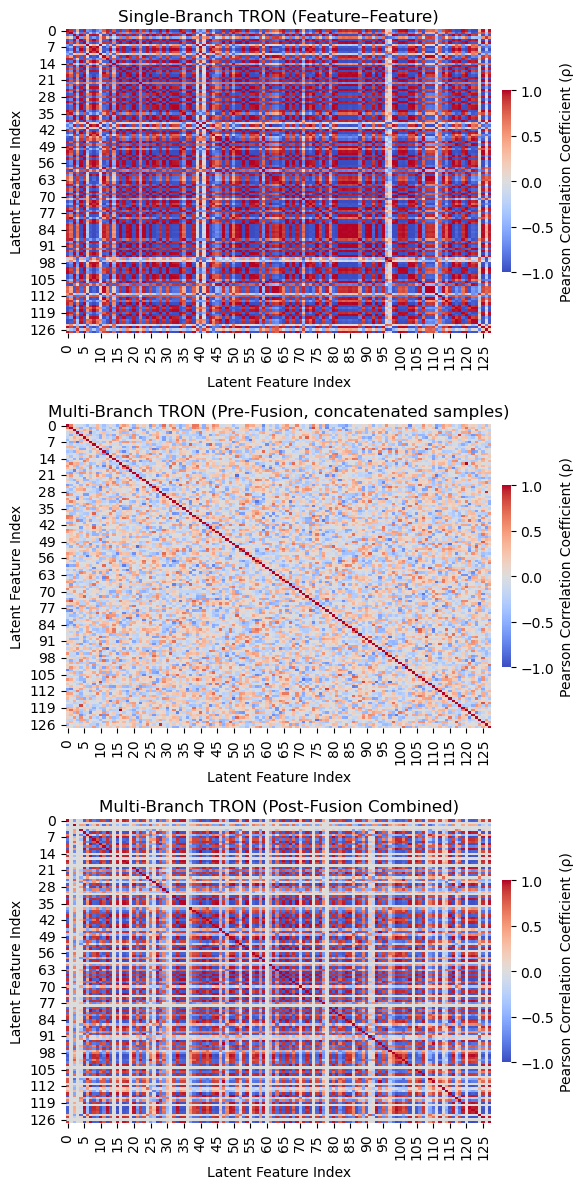

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 1. SAFE UTILS  (keeps full 128×128 matrices)
# ============================================================

def zscore_cols(X, eps=1e-12):
    """Z-score each latent feature column across samples."""
    mu = np.mean(X, axis=0, keepdims=True)
    sd = np.std(X, axis=0, keepdims=True)
    return (X - mu) / np.clip(sd, eps, None)

def safe_corrcoef(X):
    """
    Compute full correlation matrix (128x128) safely without divide warnings.
    Replaces NaN and inf values with 0.
    """
    Xz = zscore_cols(X)
    # Replace any columns that are still constant with zeros
    if np.any(np.isnan(Xz)) or np.any(np.isinf(Xz)):
        Xz = np.nan_to_num(Xz, nan=0.0, posinf=0.0, neginf=0.0)
    # Compute correlation
    C = np.corrcoef(Xz, rowvar=False)
    C = np.nan_to_num(C, nan=0.0, posinf=0.0, neginf=0.0)
    return C


def mean_abs_corr(C):
    """Mean |ρ| excluding the diagonal."""
    tri = np.triu_indices_from(C, 1)
    return np.mean(np.abs(C[tri]))


# ============================================================
# 2. LATENT EXTRACTION HELPERS
# ============================================================

def extract_latent_single_batch(model, seq_batch):
    model.eval()
    with torch.no_grad():
        _, (h_n, _) = model.branch_net.lstm(seq_batch)
        latent = model.branch_net.layer_norm(h_n[-1])
        latent = model.branch_net.fc(latent)
    return latent.cpu().numpy()  # [batch, hidden_dim]


def extract_latent_multi_batch(model, seq_batch_dict):
    model.eval()
    latents = []
    with torch.no_grad():
        for key, net in model.branches.items():
            seq = seq_batch_dict[key]
            _, (h_n, _) = net.lstm(seq)
            latent = net.layer_norm(h_n[-1])
            latent = net.fc(latent)
            latents.append(latent.cpu().numpy())
    return latents  # list of [batch, hidden_dim]


def extract_combined_batch(model, seq_batch_dict):
    model.eval()
    branch_latents = []
    with torch.no_grad():
        for key, net in model.branches.items():
            seq = seq_batch_dict[key]
            _, (h_n, _) = net.lstm(seq)
            latent = net.layer_norm(h_n[-1])
            latent = net.fc(latent)
            branch_latents.append(latent)
        combined = torch.prod(torch.stack(branch_latents, dim=0), dim=0)
    return combined.cpu().numpy()  # [batch, hidden_dim]


# ============================================================
# 3. ACCUMULATE LATENTS OVER TEST SET
# ============================================================

def collect_latents_over_loader(s_model, m_model, s_loader, m_loader, device, max_batches=64):
    """Aggregate multiple batches for statistically stable correlations."""
    single_all, post_all = [], []
    multi_each_all = None
    it_s, it_m = iter(s_loader), iter(m_loader)

    for _ in range(max_batches):
        try:
            s_batch = next(it_s)
            m_batch = next(it_m)
        except StopIteration:
            break

        s_seq = s_batch[0].to(device)
        m_seq = {k: v.to(device) for k, v in m_batch[0].items()}

        sb = extract_latent_single_batch(s_model, s_seq)
        mb_list = extract_latent_multi_batch(m_model, m_seq)
        cb = extract_combined_batch(m_model, m_seq)

        single_all.append(sb)
        post_all.append(cb)

        if multi_each_all is None:
            multi_each_all = [mb_list[i] for i in range(len(mb_list))]
        else:
            for i in range(len(mb_list)):
                multi_each_all[i] = np.vstack([multi_each_all[i], mb_list[i]])

    single_all = np.vstack(single_all)
    post_all = np.vstack(post_all)
    return single_all, multi_each_all, post_all


# ============================================================
# 4. RUN COLLECTION
# ============================================================

single_lat, multi_each_lat_list, post_lat = collect_latents_over_loader(
    s_model, m_model, s_test_loader, m_test_loader, device, max_batches=64
)

print("Collected latent shapes:")
print("  single:", single_lat.shape)
print("  multi_each[0]:", multi_each_lat_list[0].shape)
print("  post:", post_lat.shape)


# ============================================================
# 5. CORRELATION CALCULATIONS (keeps 128×128)
# ============================================================

# Single-branch correlation
C_single = safe_corrcoef(single_lat)
mean_single = mean_abs_corr(C_single)

# Multi-branch pre-fusion (concatenate all sensors)
pre_concat = np.concatenate(multi_each_lat_list, axis=0)  # [S*N, HD]
C_pre = safe_corrcoef(pre_concat)
mean_multi_pre = mean_abs_corr(C_pre)

# Post-fusion
C_post = safe_corrcoef(post_lat)
mean_multi_post = mean_abs_corr(C_post)

# Inter-sensor correlation (pairwise flattened)
S = len(multi_each_lat_list)
pairwise = []
for i in range(S):
    vi = multi_each_lat_list[i].reshape(-1)
    for j in range(i + 1, S):
        vj = multi_each_lat_list[j].reshape(-1)
        c = np.corrcoef(vi, vj)[0, 1]
        if not np.isnan(c):
            pairwise.append(abs(c))
corr_inter_sensor = float(np.mean(pairwise)) if pairwise else np.nan


# ============================================================
# 6. PRINT RESULTS
# ============================================================

print(f"Mean feature–feature correlation (single-branch):        {mean_single:.3f}")
print(f"Mean feature–feature correlation (multi-branch pre):     {mean_multi_pre:.3f}")
print(f"Mean feature–feature correlation (multi-branch post):    {mean_multi_post:.3f}")
print(f"Mean inter-sensor correlation (multi-branch pre-fusion): {corr_inter_sensor:.3f}")


# ============================================================
# 7. VISUALIZATION  (all 128×128)
# ============================================================

fig, axes = plt.subplots(3, 1, figsize=(6, 12))

sns.heatmap(C_single, ax=axes[0], cmap="coolwarm", vmin=-1, vmax=1,
            cbar=True, cbar_kws={"shrink": 0.6, "pad": 0.02})
axes[0].set_title("Single-Branch TRON (Feature–Feature)")

sns.heatmap(C_pre, ax=axes[1], cmap="coolwarm", vmin=-1, vmax=1,
            cbar=True, cbar_kws={"shrink": 0.6, "pad": 0.02})
axes[1].set_title("Multi-Branch TRON (Pre-Fusion, concatenated samples)")

sns.heatmap(C_post, ax=axes[2], cmap="coolwarm", vmin=-1, vmax=1,
            cbar=True, cbar_kws={"shrink": 0.6, "pad": 0.02})
axes[2].set_title("Multi-Branch TRON (Post-Fusion Combined)")

for ax in axes:
    ax.set_xlabel("Latent Feature Index")
    ax.set_ylabel("Latent Feature Index")
    cbar = ax.collections[0].colorbar
    cbar.set_label("Pearson Correlation Coefficient (ρ)", fontsize=10)

plt.tight_layout()
#plt.savefig("analysis/branch/latent_correlation_matrices_fixed128.png",dpi=300, bbox_inches="tight")
plt.show()
